# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

### Load features and labels into dataframe from csv file 

In [45]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


### Create test-train split

In [46]:
from sklearn.model_selection import train_test_split

y = data.label
X = data.drop('label', axis=1)

# Need to find logical nubmers for test_size and random_state and add this in the report. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Preprocessing

In [47]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest

scaler = MinMaxScaler()
random_forest = RandomForestClassifier()

preprocess = FeatureUnion([('pca', PCA()), ("kbest", SelectKBest(k=5))])

pipe = Pipeline(steps=[('scale', scaler), ("kbest", SelectKBest(k=100)), ("random_forest", random_forest)])

### Gridsearch for optimal hyperparameters Random Forest Classifer 

In [48]:
from sklearn.model_selection import GridSearchCV

parameters = {'random_forest__n_estimators': [50,100], 'kbest__k': [1, 10, 50, 100]}
search = GridSearchCV(pipe, parameters, cv= 3, scoring = 'f1', verbose=5)
search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END kbest__k=1, random_forest__n_estimators=50;, score=0.250 total time=   0.2s
[CV 2/3] END kbest__k=1, random_forest__n_estimators=50;, score=0.206 total time=   0.2s
[CV 3/3] END kbest__k=1, random_forest__n_estimators=50;, score=0.169 total time=   0.2s
[CV 1/3] END kbest__k=1, random_forest__n_estimators=100;, score=0.245 total time=   0.3s
[CV 2/3] END kbest__k=1, random_forest__n_estimators=100;, score=0.203 total time=   0.3s
[CV 3/3] END kbest__k=1, random_forest__n_estimators=100;, score=0.169 total time=   0.3s
[CV 1/3] END kbest__k=10, random_forest__n_estimators=50;, score=0.318 total time=   0.2s
[CV 2/3] END kbest__k=10, random_forest__n_estimators=50;, score=0.429 total time=   0.2s
[CV 3/3] END kbest__k=10, random_forest__n_estimators=50;, score=0.391 total time=   0.2s
[CV 1/3] END kbest__k=10, random_forest__n_estimators=100;, score=0.318 total time=   0.3s
[CV 2/3] END kbest__k=10, random_forest__n

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('kbest', SelectKBest(k=100)),
                                       ('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'kbest__k': [1, 10, 50, 100],
                         'random_forest__n_estimators': [50, 100]},
             scoring='f1', verbose=5)

In [49]:
evaluation_grid= pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
evaluation_grid.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)

,param_kbest__k,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,50,100,"{'kbest__k': 50, 'random_forest__n_estimators'...",0.488889,0.461538,0.200000,0.383476,0.130217,1
2,10,50,"{'kbest__k': 10, 'random_forest__n_estimators'...",0.318182,0.428571,0.391304,0.379353,0.045852,2
4,50,50,"{'kbest__k': 50, 'random_forest__n_estimators'...",0.468085,0.307692,0.355556,0.377111,0.067231,3
7,100,100,"{'kbest__k': 100, 'random_forest__n_estimators...",0.510638,0.320000,0.279070,0.369903,0.100908,4
6,100,50,"{'kbest__k': 100, 'random_forest__n_estimators...",0.488889,0.352941,0.266667,0.369499,0.091474,5
3,10,100,"{'kbest__k': 10, 'random_forest__n_estimators'...",0.318182,0.352941,0.416667,0.362597,0.040782,6
0,1,50,"{'kbest__k': 1, 'random_forest__n_estimators':...",0.250000,0.205882,0.169492,0.208458,0.032918,7
1,1,100,"{'kbest__k': 1, 'random_forest__n_estimators':...",0.244898,0.202899,0.169492,0.205763,0.030851,8


### Evaluation of classifier 

In [50]:
from sklearn.metrics import f1_score, confusion_matrix
best_clf = search.best_estimator_
y_pred = best_clf.predict(X_test)
f1_score(y_test, y_pred)


0.34375

In [51]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['normal', 'abnormal'], index= ['normal', 'abnormal'])

,normal,abnormal
normal,220,7
abnormal,35,11


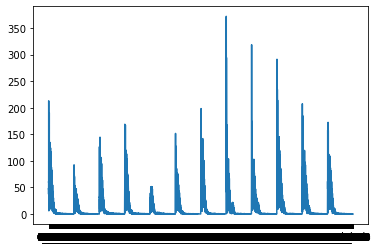

In [16]:
import matplotlib.pyplot as plt
plt.plot(data.iloc[0,:])